In [1]:
import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import os

In [2]:
import sys
print(sys.path) 
sys.path.append("/cellar/users/mpagadal/Programs/anaconda3/lib/python3.7/site-packages")
sys.path.insert(1, '/cellar/users/mpagadal/Data/gcta/scripts')

['/data/cellardata2/users/mpagadal/projects/germline-immune/snp-interactions/notebooks', '/nrnb/opt/anaconda3.7/lib/python37.zip', '/nrnb/opt/anaconda3.7/lib/python3.7', '/nrnb/opt/anaconda3.7/lib/python3.7/lib-dynload', '', '/cellar/users/mpagadal/.local/lib/python3.7/site-packages', '/nrnb/opt/anaconda3.7/lib/python3.7/site-packages', '/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/IPython/extensions', '/cellar/users/mpagadal/.ipython']


In [3]:
import statsmodels.stats.multitest as multi
from adjustText import adjust_text

In [4]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [5]:
import networkx as nx
from ndex2.nice_cx_network import NiceCXNetwork 
import ndex2.client as nc
import ndex2

In [6]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [7]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib_venn import venn3

## Get filtered associations

In [8]:
def fdr(df):
    probabilities = df["P"].to_numpy()
    report = multi.multipletests(probabilities,
                alpha=0.05,
                method="fdr_bh",
                is_sorted=False,
            )
    discoveries = report[1]
    df["fdr"]=discoveries
    df["fdr"]=pd.to_numeric(df["fdr"])
    df["-log10(fdr)"]=-np.log10(df["fdr"])
    
    return(df)

### run extract-snps.sh

In [9]:
directory="/cellar/users/mpagadal/Data2/projects/germline-immune/discovery/associations/filtered/tpm/"
files=os.listdir(directory)

compiled=pd.DataFrame()

for x in files:
    try:
        df=pd.read_csv(directory+x,delimiter="\t",header=None)
        df=df[df[6]=="ADD"]
        df["file"]=x.split(".sig.snps")[0]
        compiled=compiled.append(df)
    except:
        print(x)
    


In [10]:
df_plot=compiled.pivot(index=2, columns="file", values=8)

### get PCA-related snps

In [11]:
pca="PC1"
pheno="/cellar/users/mpagadal/Data2/projects/germline-immune/snp-interactions/associations/mac-reg/Macrophage.Regulation.Macrophage.Regulation.glm.linear"

In [12]:
pc=pd.read_csv("/cellar/users/mpagadal/Data2/projects/germline-immune/snp-tables/immune-microenvironment-pc.tsv",delimiter="\t")
pc_snps=pc[pc["pc"]==pca]["ID"].tolist()

### Get macrophage regulation phenotype

In [13]:
assoc=pd.read_csv(pheno,delimiter="\t")
assoc=assoc[(assoc["ID"].isin(pc_snps))&(assoc["TEST"]=="ADD")]
assoc=fdr(assoc)

In [14]:
up=[]
down=[]

for i,row in assoc.iterrows():
    if row["BETA"]<0:
        df_plot.loc[row["ID"]]*=-1
        down.append(row["ID"])
    else:
        up.append(row["ID"])

In [15]:
df_plot=df_plot[df_plot.index.isin(pc_snps)]

### Get pearson correlation matrix

In [16]:
df_plot=df_plot.T
df_plot_corr=df_plot.corr(method="pearson")

<Figure size 720x720 with 0 Axes>

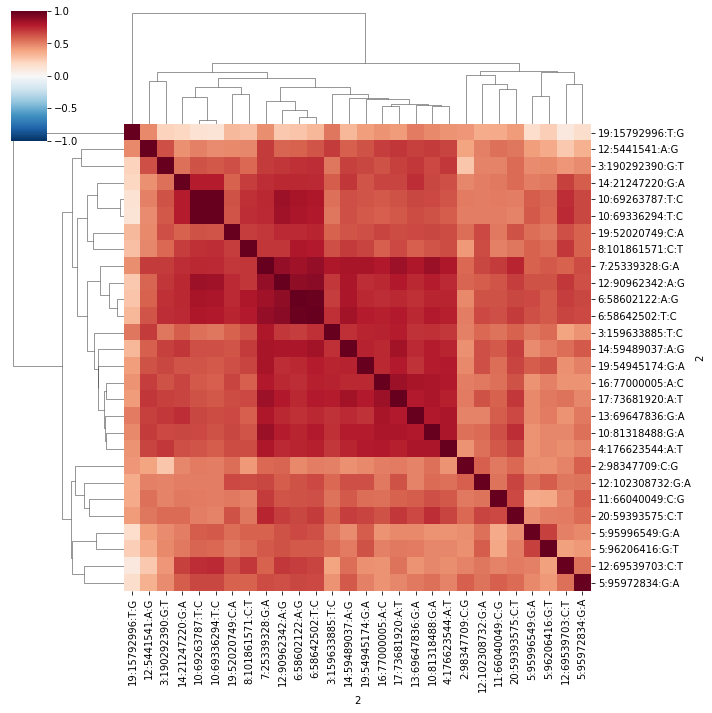

In [17]:
f=plt.figure(figsize=(10,10))
ax=sns.clustermap(df_plot_corr,cmap="RdBu_r",vmax=1,vmin=-1)
plt.savefig("../plots/"+pca+"pleiotropy.clustermap.pdf", bbox_inches='tight')

In [18]:
df=ax.data2d
df=df.rename_axis("snp")

In [19]:
df=df.stack().reset_index()
df.columns=["snp1","snp2","pearson"]

In [20]:
df.to_csv("../data/"+pca+"-pearson-correlation-matrix.tsv",index=None,sep="\t")

## Get association statistics with Macrophage Regulation

In [21]:
def fdr(df):
    probabilities = df["P"].to_numpy()
    report = multi.multipletests(probabilities,
                alpha=0.05,
                method="fdr_bh",
                is_sorted=False,
            )
    discoveries = report[1]
    df["fdr"]=discoveries
    df["fdr"]=pd.to_numeric(df["fdr"])
    df["-log10(fdr)"]=-np.log10(df["fdr"])
    
    return(df)

## Get cis-trans status

In [22]:
snps=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/snp-tables/immune-microenvironment-nonhla.tsv",delimiter="\t")

In [23]:
trans=snps[snps["cis tss"].isnull()]["snps"].tolist()

In [24]:
mac_color=[]

#get macrophage regulation associations

for x in df_plot_corr.columns:
    if x in trans:
        mac_color.append("green")
    else:
        mac_color.append("lightgreen")

In [25]:
mp_pheno=dict(zip(assoc["ID"],assoc["BETA"]))

In [26]:
import matplotlib.cm as cm

In [27]:
df_color=pd.DataFrame({"snps":df_plot_corr.index.tolist()})

In [28]:
df_color["pheno"]=df_color.snps.map(mp_pheno)

In [29]:
minima = min(df_color["pheno"].tolist())
maxima = max(df_color["pheno"].tolist())

In [30]:
norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.RdBu_r)

colors=[]

for v in df_color["pheno"].tolist():
    colors.append(mapper.to_rgba(abs(v)))


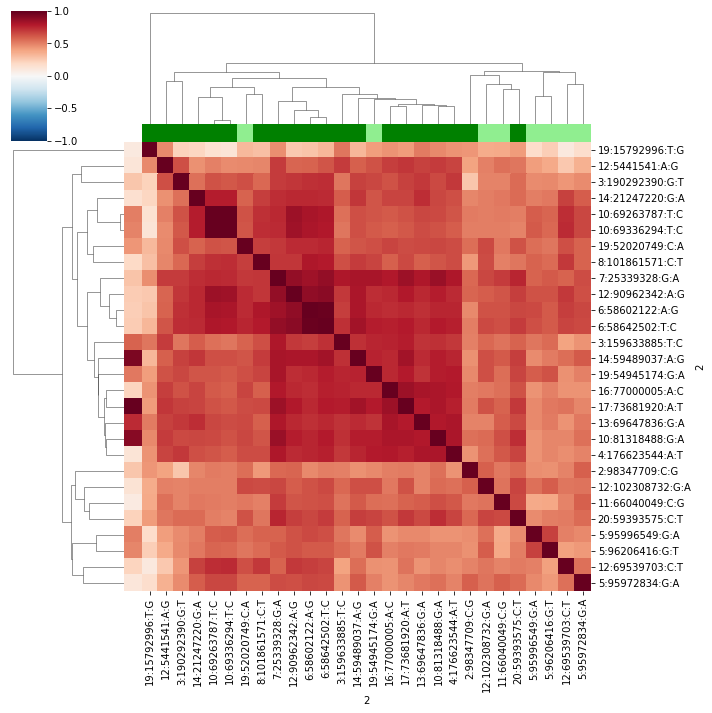

In [31]:
cluster=sns.clustermap(df_plot_corr,cmap="RdBu_r",vmax=1,vmin=-1,col_colors=[mac_color],row_colors=colors)
plt.savefig("../plots/"+pca+"pleiotropy.clustermap.pdf", bbox_inches='tight')